# Face Detection using Cascade Classifier

## Description
Face Detection is a computer vision problem that aims to attempt to accurately identify human faces that may, or may not, be present in a given photograph or video. Many efforts have been directed at this problem since the early 2000's, with it having started as a subbranch of the problem of Object-Class Detection but having evolved into a main focus of machine learning algorithms due to its prevalence and paramountcy to the paradigm of Facial Recognition, another problem that is nowadays used in a wide-branch of technologies and biometrics.

## Face Detection Function

### Imports

In [2]:
import cv2
import os
from os import listdir
from os.path import isfile, join
import time
from matplotlib import pyplot as plt
from random import shuffle

### Initialize Cascade Classifier

In [3]:
def initCascade(path):
    cascadeClassifier = cv2.CascadeClassifier()
    
    # Try to load the model
    if not cascadeClassifier.load(cv2.samples.findFile(path)):
        print("Error - Unable to load classifier")
        exit(0)
    
    return cascadeClassifier

### Detect Faces

In [4]:
def detectFaces(classifier, imgPath, scaleFactor = 1.1, minNeighbors = 3):
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get the Faces
    faces = classifier.detectMultiScale(
        img,
        scaleFactor,
        minNeighbors,
    )
    
    #print(faces)
    
    return faces

### Draw Boxes

In [5]:
def drawBoxes(imgPath, rects):
    img = cv2.imread(imgPath)

    # Draw the bounding boxes
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 3)
    
    cv2.imshow("Detected Faces", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Write Results

In [6]:
def writeResults(path, faces, filename):
    with open("./CascadeClassifier/pred/"+filename, "a") as writer:
        #print("Writing results for image " + path.split("/")[1])
        writer.write(path.split("/")[-1].rstrip()+"\n")
        writer.write(str(len(faces))+"\n")
        
        for (x,y,w,h) in faces:
            faceCoords = str(x)+" "+str(y)+" "+str(w)+" "+str(h)
            
            writer.write(faceCoords+"\n")
        

### Compare Results

In [7]:
def compare_results(results_file, expected_file):
    image_faces = {}
    
    with open(expected_file, "r") as reader:
        while True:
            image_dir = reader.readline()
            if not image_dir: 
                break
            image_faces[image_dir] = []
            num_faces = int(reader.readline())
            for i in range(num_faces):
                image_faces[image_dir].append([int(elem) for elem in reader.readline().rstrip().split()])
                
    true_pos = 0
    false_pos = 0
    false_neg = 0
    with open(results_file, "r") as reader:
        while True:
            image_dir = reader.readline()
            
            if not image_dir:
                return true_pos, false_pos, false_neg
            
            expected_images = image_faces[image_dir]
            num_found_faces = int(reader.readline())
            
            for i in range(num_found_faces):
                start_x, start_y, width, height = [int(elem) for elem in reader.readline().split()]
                ## In order to be recognized as a face, it has to be within bounds, therfore
                compatible_index = -1
                
                for i in range(len(expected_images)):
                    expected_face = expected_images[i]
                    if start_x > expected_face[0] - 5 and start_y > expected_face[1] - 5 \
                    and start_x + width < expected_face[2] + 5 and start_y < expected_face[3] + 5:
                        compatible_index = i
                        break
                        
                if compatible_index != -1:
                    true_pos += 1
                    expected_images.pop(compatible_index)
                else:
                    false_pos += 1

            false_neg += len(expected_images)

### Compare Binary

In [8]:
def compare_bin_results(img_dir, results):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    with open(results, "r") as reader:
        while True:
            image = reader.readline().rstrip()
            if not image:
                return true_pos, true_neg, false_pos, false_neg
            num_found_faces = int(reader.readline())
            if num_found_faces == 0:
                if image[0:3] == "Pos": 
                    false_neg += 1
                else:
                    true_neg += 1
            for i in range(num_found_faces):
                start_x, start_y, width, height = [int(elem) for elem in reader.readline().split()]
                if image[0:3] == "Pos": #It's a positive image, we check if width and height are closer to the image
                    true_pos += 1
                    #real_height, real_width, _ = cv2.imread(img_dir + image).shape
                    #if abs(real_width - width) < 0.25*real_width and abs(real_height - height) < 0.25*real_height:
                    #    true_pos += 1
                    #else:
                    #    false_pos += 1
                else:
                    false_pos += 1

## Pretrained Model - haarcascade_frontalface_default.xml

In this section we will be using one of OpenCV's pretrained models for cascade classifier face detection.

In [88]:
#classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

#Get values for a specific image
path = "./ImageResources/Dataset/WIDER_train/images/0--Parade/0_Parade_Parade_0_178.jpg"
path2 = "./ImageResources/Dataset/WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_138.jpg"
path3 = "./dg.jpg"


faces = detectFaces(classifier, path2,  minNeighbors = 8, scaleFactor = 1.1)
drawBoxes(path2, faces)


### Default Values

In [11]:
# Get values for our Test Set

path = "./ImageResources/Dataset/WIDER_test/images"

classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

results = open("./CascadeClassifier/pred/noTrain.txt", "w")
results.close()

list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

start = time.time()
for img in list_imgs:
    
    faces = detectFaces(classifier, img)
    writeResults(img,faces, "noTrain.txt")
    
end = time.time()
print("It took " + str(end - start) + " to finish results for the pretrained model stages")

answers = "./ImageResources/Dataset/WIDER_test/test.txt"
tp_d, fp_d, fn_d = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
print("Correctly found", tp_d)
print("Incorrectly found", fp_d)
print("Could not find", fn_d)

It took 104.62989473342896 to finish results for the pretrained model stages
Correctly found 1252
Incorrectly found 3607
Could not find 18753


NameError: name 'compare_results_binary' is not defined

In [15]:
path = "./ImageResources/Dataset/WIDER_test/cropped_images"

classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")

results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
results.close()

list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

start = time.time()
for img in list_imgs:
    
    faces = detectFaces(classifier, img)
    writeResults(img,faces, "noTrainBin.txt")
    
end = time.time()
print("It took " + str(end - start) + " to finish results for the pretrained model stages")

tp_d2, tn_d2, fp_d2, fn_d2 = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
print("Correctly found", tp_d2)
print("Correctly not found", tn_d2)
print("Incorrectly found", fp_d2)
print("Could not find", fn_d2)

It took 117.37798118591309 to finish results for the pretrained model stages
Correctly found 835
Correctly not found 9790
Incorrectly found 249
Could not find 9194


### Changing Neighbors

In [8]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr = []
fp_arr = []
fn_arr = []

tp_arr_b = []
tn_arr_b = []
fp_arr_b = []
fn_arr_b = []

acc_arr = []
recall_arr = []

acc_arr_b = []
recall_arr_b = []

for neighbours in range(1,10):
    classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
    
    results = open("./CascadeClassifier/pred/noTrain.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbors=neighbours)
        writeResults(img,faces, "noTrain.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
    
    tp_arr.append(tp)
    fp_arr.append(fp)
    fn_arr.append(fn)
    
    results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
    results.close()

    list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbors=neighbours)
        writeResults(img,faces, "noTrainBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
    
    tp_arr_b.append(tp)
    tn_arr_b.append(tn)
    fp_arr_b.append(fp)
    fn_arr_b.append(fn)



It took 129.7256646156311 to finish results for the pretrained model stages
It took 137.95983815193176 to finish results for the pretrained model stages
It took 157.30901551246643 to finish results for the pretrained model stages
It took 161.6300950050354 to finish results for the pretrained model stages
It took 143.19811415672302 to finish results for the pretrained model stages
It took 165.48867392539978 to finish results for the pretrained model stages
It took 167.16038346290588 to finish results for the pretrained model stages
It took 167.54135036468506 to finish results for the pretrained model stages
It took 160.36675810813904 to finish results for the pretrained model stages


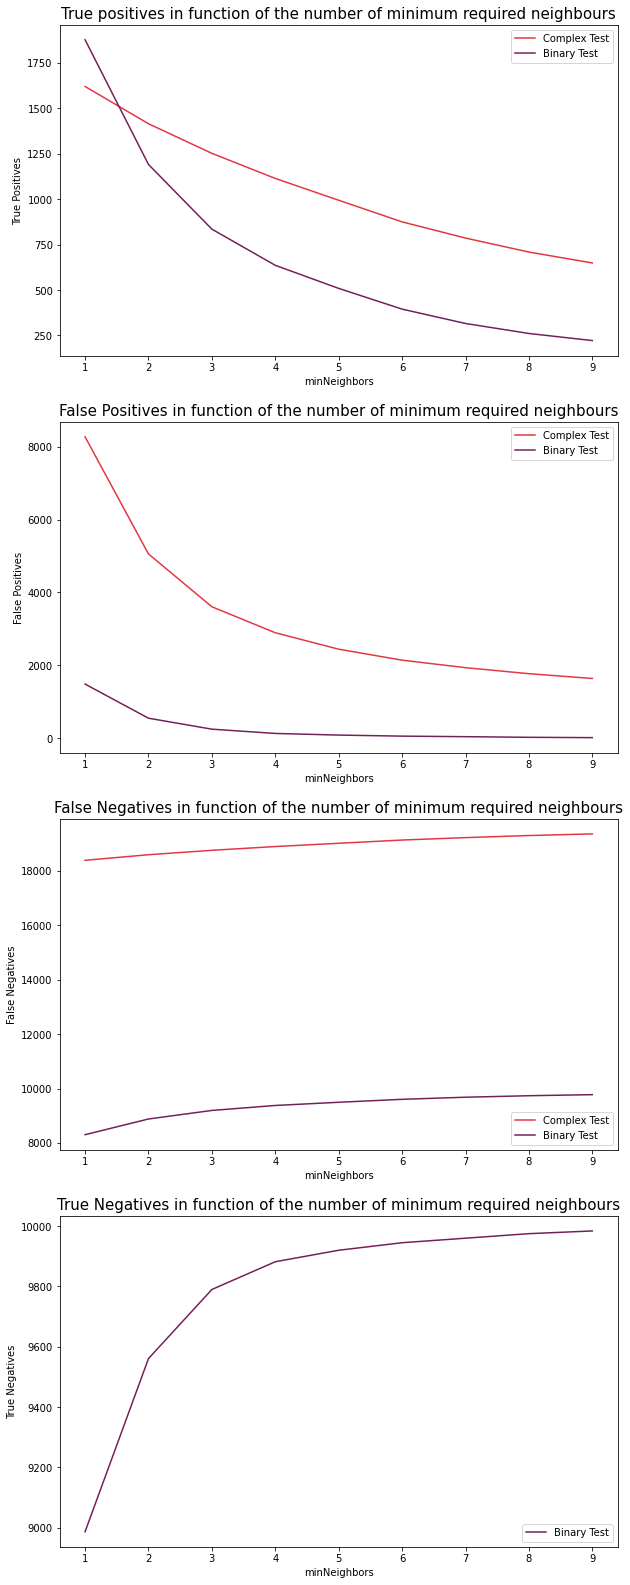

In [52]:
tp_arr = [1620, 1415, 1252, 1114, 994, 875, 786, 709, 649]
fp_arr = [8269, 5056, 3607, 2894, 2443, 2142, 1936, 1771, 1640]
fn_arr = [18385, 18590, 18753, 18891, 19011, 19130, 19219, 19296, 19356]

tp_arr_b = [1877, 1191, 835, 636, 509, 395, 316, 261, 222]
fp_arr_b = [1486, 550, 249, 132, 87, 58, 43, 26, 17]
fn_arr_b = [8303, 8880, 9194, 9377, 9494, 9603, 9680, 9735, 9774]
tn_arr_b = [8987, 9561, 9790, 9882, 9920, 9945, 9960, 9975, 9984]

plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(range(1,10), tp_arr, color="#e33641", label="Complex Test")
plt.plot(range(1,10), tp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('minNeighbors')
plt.ylabel('True Positives')
plt.title('True positives in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(4,1,2)
plt.plot(range(1,10), fp_arr, color="#e33641", label="Complex Test")
plt.plot(range(1,10), fp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('minNeighbors')
plt.ylabel('False Positives')
plt.title('False Positives in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(4,1,3)
plt.plot(range(1,10), fn_arr, color="#e33641", label="Complex Test")
plt.plot(range(1,10), fn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('minNeighbors')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(4,1,4)
plt.plot(range(1,10), tn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('minNeighbors')
plt.ylabel('True Negatives')
plt.title('True Negatives in function of the number of minimum required neighbours',fontsize=15)

plt.show()

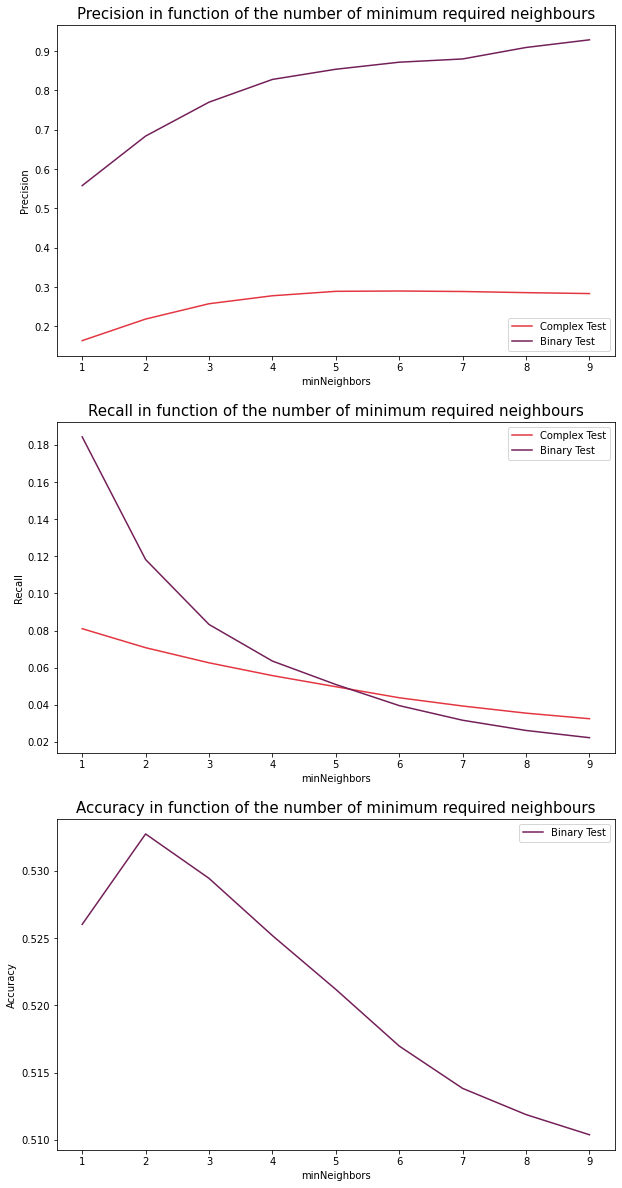

In [55]:
tp_acc_b = []

tp_pre = []
tp_pre_b = []

tp_rec = []
tp_rec_b = []

for i in range(0,9):
    pre = tp_arr[i] / (tp_arr[i] + fp_arr[i])
    rec = tp_arr[i] / (tp_arr[i] + fn_arr[i])
    
    tp_pre.append(pre)
    tp_rec.append(rec)
    
for i in range(0,9):
    pre = tp_arr_b[i] / (tp_arr_b[i] + fp_arr_b[i])
    rec = tp_arr_b[i] / (tp_arr_b[i] + fn_arr_b[i])
    acc = (tp_arr_b[i] + tn_arr_b[i]) / (tp_arr_b[i] + fp_arr_b[i] + fn_arr_b[i] + tn_arr_b[i])
    
    tp_pre_b.append(pre)
    tp_rec_b.append(rec)
    tp_acc_b.append(acc)
    
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(range(1,10), tp_pre, color="#e33641", label="Complex Test")
plt.plot(range(1,10), tp_pre_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('minNeighbors')
plt.ylabel('Precision')
plt.title('Precision in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(4,1,2)
plt.plot(range(1,10), tp_rec, color="#e33641", label="Complex Test")
plt.plot(range(1,10), tp_rec_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('minNeighbors')
plt.ylabel('Recall')
plt.title('Recall in function of the number of minimum required neighbours',fontsize=15)

plt.subplot(4,1,3)
plt.plot(range(1,10), tp_acc_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('minNeighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the number of minimum required neighbours',fontsize=15)

plt.show()

### Changing Scale Factor

In [57]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr2 = []
fp_arr2 = []
fn_arr2 = []

acc_arr2 = []
recall_arr2 = []

tp_arr2_b = []
tn_arr2_b = []
fp_arr2_b = []
fn_arr2_b = []

acc_arr2_b = []
recall_arr2_b = []

neighbours = 6 #Substitute for optimal number of neighbours
for scale_factor in [1.05, 1.10, 1.15, 1.20, 1.25]:
    classifier = initCascade("./CascadeClassifier/haarcascade_frontalface_default.xml")
    
    results = open("./CascadeClassifier/pred/noTrain.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, scaleFactor=scale_factor)
        writeResults(img,faces, "noTrain.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/noTrain.txt", answers)
    
    tp_arr2.append(tp)
    fp_arr2.append(fp)
    fn_arr2.append(fn)
    
    results = open("./CascadeClassifier/pred/noTrainBin.txt", "w")
    results.close()

    list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, scaleFactor=scale_factor)
        writeResults(img,faces, "noTrainBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/noTrainBin.txt")
    
    tp_arr2_b.append(tp)
    tn_arr2_b.append(tn)
    fp_arr2_b.append(fp)
    fn_arr2_b.append(fn)

KeyboardInterrupt: 

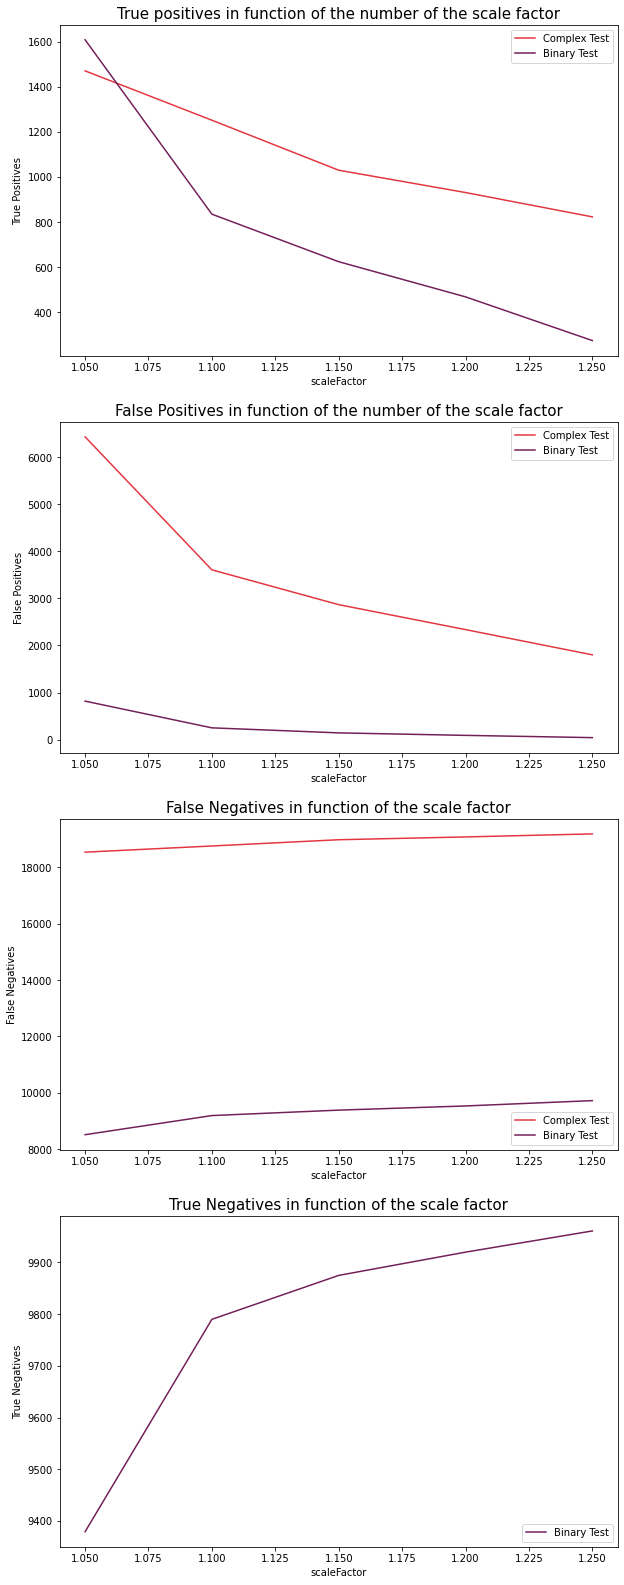

In [71]:
tp_arr = [1471, 1252, 1030, 931, 823]
fp_arr = [6434, 3607, 2867, 2337, 1801]
fn_arr = [18534, 18753, 18975, 19074, 19182]

tp_arr_b = [1609, 835, 624, 468, 274]
fp_arr_b = [817, 249, 142, 89, 41]
fn_arr_b = [8516, 9194, 9387, 9535, 9724]
tn_arr_b = [9379, 9790, 9875, 9920, 9961]


plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_arr, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('scaleFactor')
plt.ylabel('True Positives')
plt.title('True positives in function of the number of the scale factor',fontsize=15)

plt.subplot(4,1,2)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], fp_arr, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], fp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('scaleFactor')
plt.ylabel('False Positives')
plt.title('False Positives in function of the number of the scale factor',fontsize=15)

plt.subplot(4,1,3)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], fn_arr, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], fn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('scaleFactor')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the scale factor',fontsize=15)

plt.subplot(4,1,4)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('scaleFactor')
plt.ylabel('True Negatives')
plt.title('True Negatives in function of the scale factor',fontsize=15)

plt.show()

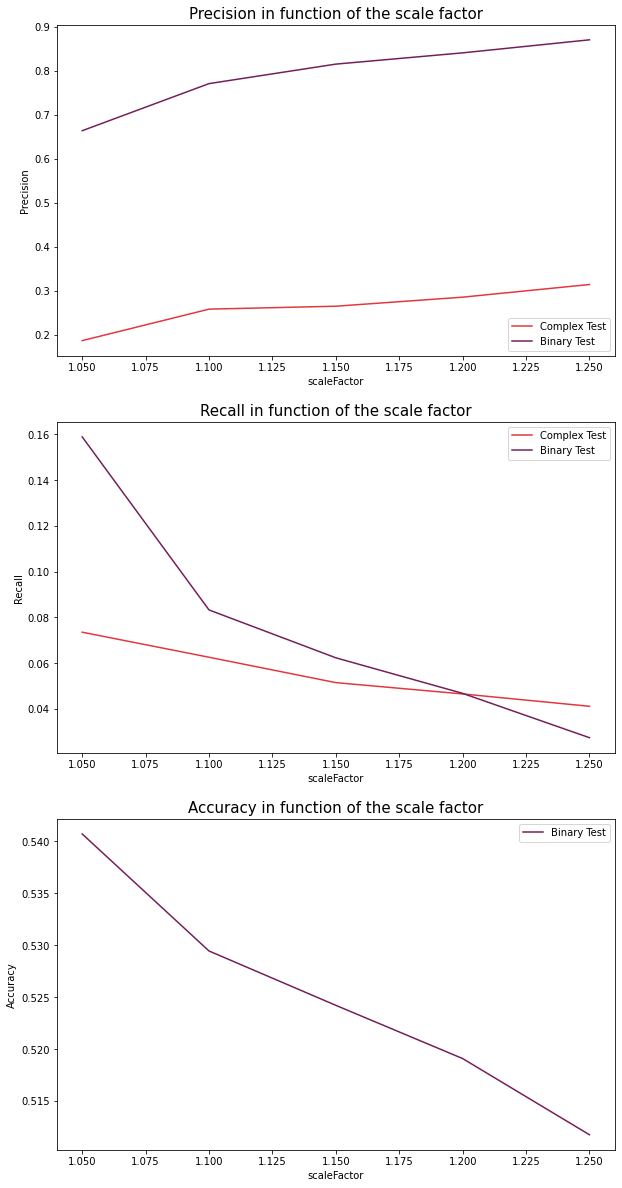

In [72]:
tp_acc_b = []

tp_pre = []
tp_pre_b = []

tp_rec = []
tp_rec_b = []

for i in range(0,5):
    pre = tp_arr[i] / (tp_arr[i] + fp_arr[i])
    rec = tp_arr[i] / (tp_arr[i] + fn_arr[i])
    
    tp_pre.append(pre)
    tp_rec.append(rec)
    
for i in range(0,5):
    pre = tp_arr_b[i] / (tp_arr_b[i] + fp_arr_b[i])
    rec = tp_arr_b[i] / (tp_arr_b[i] + fn_arr_b[i])
    acc = (tp_arr_b[i] + tn_arr_b[i]) / (tp_arr_b[i] + fp_arr_b[i] + fn_arr_b[i] + tn_arr_b[i])
    
    tp_pre_b.append(pre)
    tp_rec_b.append(rec)
    tp_acc_b.append(acc)
    
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_pre, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_pre_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('scaleFactor')
plt.ylabel('Precision')
plt.title('Precision in function of the scale factor',fontsize=15)

plt.subplot(4,1,2)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_rec, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_rec_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('scaleFactor')
plt.ylabel('Recall')
plt.title('Recall in function of the scale factor',fontsize=15)

plt.subplot(4,1,3)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], tp_acc_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('scaleFactor')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the scale factor',fontsize=15)

plt.show()

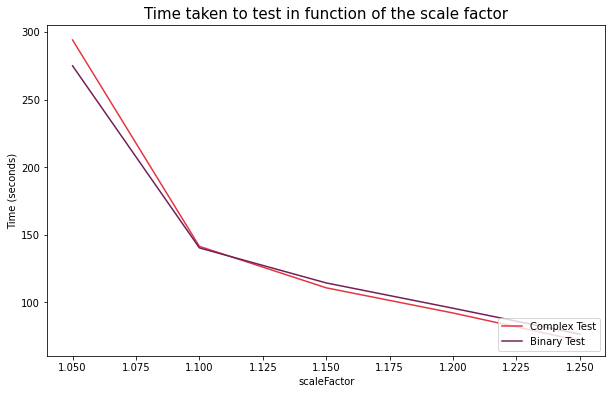

In [74]:
comp_arr = [294.19, 141.48, 110.81, 92.18, 71.64]
bin_arr = [275.06, 140.35, 114.43, 95.71, 76.52]


plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], comp_arr, color="#e33641", label="Complex Test")
plt.plot([1.05, 1.10, 1.15, 1.20, 1.25], bin_arr, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('scaleFactor')
plt.ylabel('Time (seconds)')
plt.title('Time taken to test in function of the scale factor',fontsize=15)

plt.show()

## Train Model

First you have to run the following command:
```
opencv_createsamples -info ../ImageResources/Dataset/WIDER_train/cropped_images/positive_info.dat -num 10000 -w 32 -h 32 -vec faces.vec
```
Where positive_info.dat should be a file containing all positive images, how many faces there in each image and their bounding boxes in the following format:
```
image_path no_faces x y width height
```

To train the classifier we need to run the following command:
```
opencv_traincascade -data model -vec faces.vec -bg negative_info.txt -numPos 2500 -numNeg 2500 -numStages 1 -w 32 -h 32 
```

Where model is a folder that we should create beforehand in which the model will be stored

_minHitRate <min_hit_rate>_ : Minimal desired hit rate for each stage of the classifier. Overall hit rate may be estimated as (min_hit_rate ^ number_of_stages), [245] §4.1.

_maxFalseAlarmRate <max_false_alarm_rate>_ : Maximal desired false alarm rate for each stage of the classifier. Overall false alarm rate may be estimated as (max_false_alarm_rate ^ number_of_stages), [245] §4.1.

_weightTrimRate <weight_trim_rate>_ : Specifies whether trimming should be used and its weight. A decent choice is 0.95.

_maxDepth <max_depth_of_weak_tree>_ : Maximal depth of a weak tree. A decent choice is 1, that is case of stumps.

_maxWeakCount <max_weak_tree_count>_ : Maximal count of weak trees for every cascade stage. The boosted classifier (stage) will have so many weak trees (<=maxWeakCount), as needed to achieve the given -maxFalseAlarmRate.

## Use Trained Model

### Changing number of stages

In [12]:
#classifier = initCascade("./CascadeClassifier/models/model1stage/cascade.xml")
#classifier = initCascade("./CascadeClassifier/models/model5stages/cascade.xml")
classifier = initCascade("./CascadeClassifier/models/model0.9995hitrate/cascade.xml")

#Get values for a specific image
path = "./ImageResources/Dataset/WIDER_train/images/0--Parade/0_Parade_Parade_0_178.jpg"
path2 = "./ImageResources/Dataset/WIDER_train/images/4--Dancing/4_Dancing_Dancing_4_138.jpg"
path3 = "./dg.jpg"
path4= "./ImageResources/Dataset/WIDER_train/images/27--Spa/27_Spa_Spa_27_37.jpg"

print("detecting faces")
faces = detectFaces(classifier, path,  minNeighbors = 6)
print("finished detecting faces")

drawBoxes(path, faces)
print("finished showing image")

detecting faces
finished detecting faces
finished showing image


#### Get Time Taken to Detect

In [ ]:
path = "./ImageResources/Dataset/wider_face_split/wider_face_val_bbx_gt.txt" #Path to the test images

print("Just one image")
times_single = []
for no_stages in ["5", "10", "15", "20", "25", "30", "35", "40"]:
    classifier = initCascade("./CascadeClassifier/models/model"+no_stages+"stages/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+no_stages+"stages.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, no_stages+"stages.txt")
        break
    end = time.time()
    
    times_single.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + no_stages + "stages")


print("Testing 100 Images")
times_multi = []
for no_stages in ["10", "15", "20", "25", "30", "35", "40"]:
    classifier = initCascade("./CascadeClassifier/models/model"+no_stages+"stages/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+no_stages+"stages.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))][:100]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, no_stages+"stages.txt")
        
    end = time.time()
    times_multi.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + no_stages + "stages")

Just one image
It took 161.10212063789368 to finish results for 5stages
It took 3.6427342891693115 to finish results for 10stages
It took 0.5239923000335693 to finish results for 15stages
It took 0.2975034713745117 to finish results for 20stages
It took 0.31205105781555176 to finish results for 25stages
It took 0.3283805847167969 to finish results for 30stages
It took 0.3810691833496094 to finish results for 35stages
It took 0.35534238815307617 to finish results for 40stages
Testing 100 Images
It took 353.66430401802063 to finish results for 10stages
It took 54.260422468185425 to finish results for 15stages
It took 40.26516342163086 to finish results for 20stages
It took 42.1054151058197 to finish results for 25stages
It took 39.73539113998413 to finish results for 30stages
It took 41.868587255477905 to finish results for 35stages


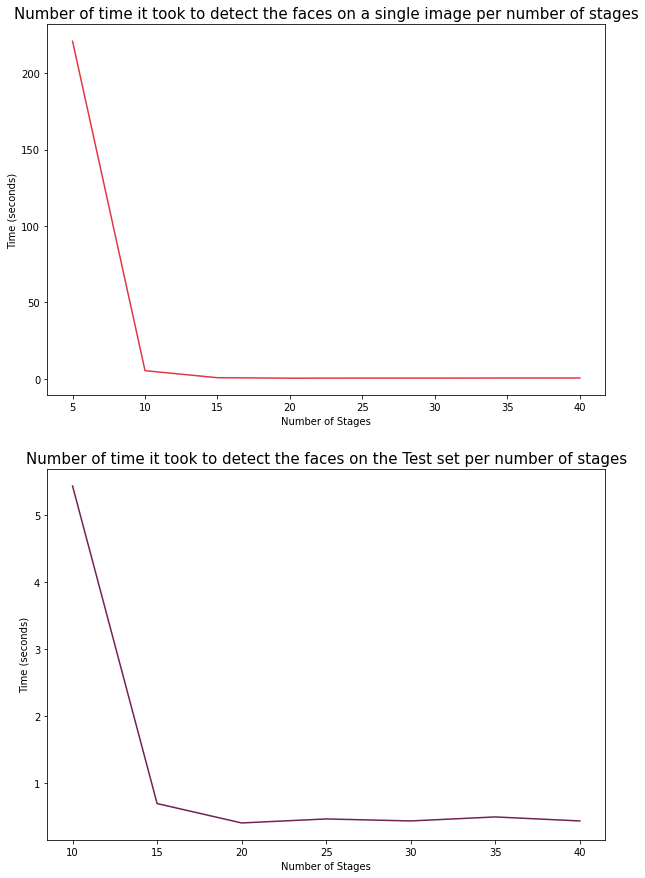

In [77]:
plt.figure(figsize = (10,15))

plt.subplot(2,1,1)
plt.plot(["5", "10", "15", "20", "25", "30", "35", "40"], times_single, color="#e33641")
plt.xlabel('Number of Stages')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on a single image per number of stages',fontsize=15)

plt.subplot(2,1,2)
plt.plot(["10", "15", "20", "25", "30", "35", "40"], times_multi, color="#731f58")
plt.xlabel('Number of Stages')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on the Test set per number of stages',fontsize=15)
plt.show()

#### Test

In [15]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr2 = []
fp_arr2 = []
fn_arr2 = []

acc_arr2 = []
recall_arr2 = []

tp_arr2_b = []
tn_arr2_b = []
fp_arr2_b = []
fn_arr2_b = []

acc_arr2_b = []
recall_arr2_b = []

list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]
shuffle(list_imgs)

for no_stages in ["15", "20", "25", "30", "35", "40"]:
    classifier = initCascade("./CascadeClassifier/models/model"+no_stages+"stages/cascade.xml")
    """
    results = open("./CascadeClassifier/pred/"+no_stages+"stages.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbours=6)
        writeResults(img,faces, no_stages+"stages.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the trained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/"+no_stages+"stages.txt", answers)
    
    tp_arr2.append(tp)
    fp_arr2.append(fp)
    fn_arr2.append(fn)
    """
    results = open("./CascadeClassifier/pred/"+no_stages+"stagesBin.txt", "w")
    results.close()
    
    start = time.time()
    for img in list_imgs[:5000]:

        faces = detectFaces(classifier, img, minNeighbors=6)
        writeResults(img,faces, no_stages+"stagesBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/"+no_stages+"stagesBin.txt")
    
    tp_arr2_b.append(tp)
    tn_arr2_b.append(tn)
    fp_arr2_b.append(fp)
    fn_arr2_b.append(fn)
    
print(tp_arr2_b)
print(fp_arr2_b)
print(fn_arr2_b)
print(tn_arr2_b)

It took 94.35851836204529 to finish results for the pretrained model stages
It took 89.51802158355713 to finish results for the pretrained model stages
It took 104.01120638847351 to finish results for the pretrained model stages
It took 87.13521695137024 to finish results for the pretrained model stages
It took 103.25083422660828 to finish results for the pretrained model stages
It took 87.42520141601562 to finish results for the pretrained model stages
[3691, 1450, 786, 203, 158, 46]
[7531, 1014, 169, 11, 5, 1]
[731, 1479, 1835, 2294, 2338, 2445]
[1256, 2093, 2401, 2498, 2504, 2508]


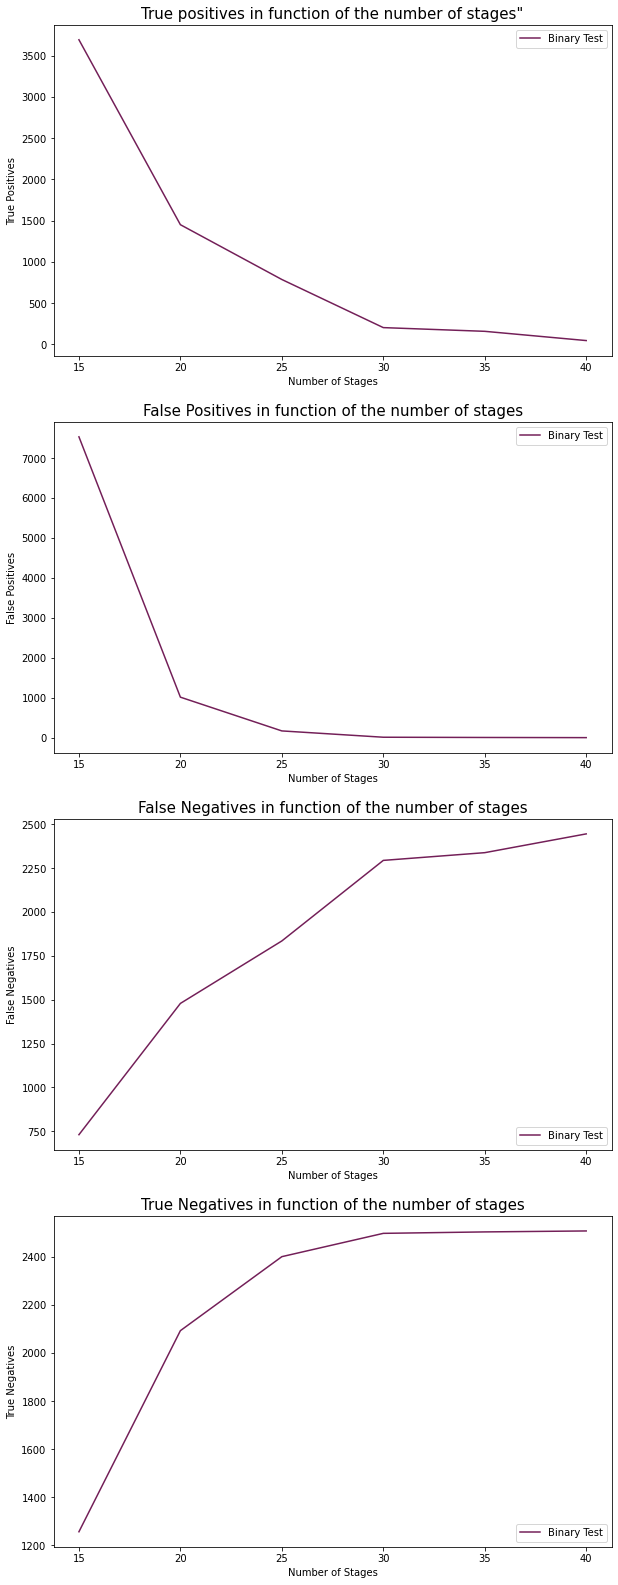

In [18]:
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["15", "20", "25", "30", "35", "40"], tp_arr2_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Number of Stages')
plt.ylabel('True Positives')
plt.title('True positives in function of the number of stages"',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["15", "20", "25", "30", "35", "40"], fp_arr2_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Number of Stages')
plt.ylabel('False Positives')
plt.title('False Positives in function of the number of stages',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["15", "20", "25", "30", "35", "40"], fn_arr2_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Number of Stages')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the number of stages',fontsize=15)

plt.subplot(4,1,4)
plt.plot(["15", "20", "25", "30", "35", "40"], tn_arr2_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Number of Stages')
plt.ylabel('True Negatives')
plt.title('True Negatives in function of the number of stages',fontsize=15)

plt.show()

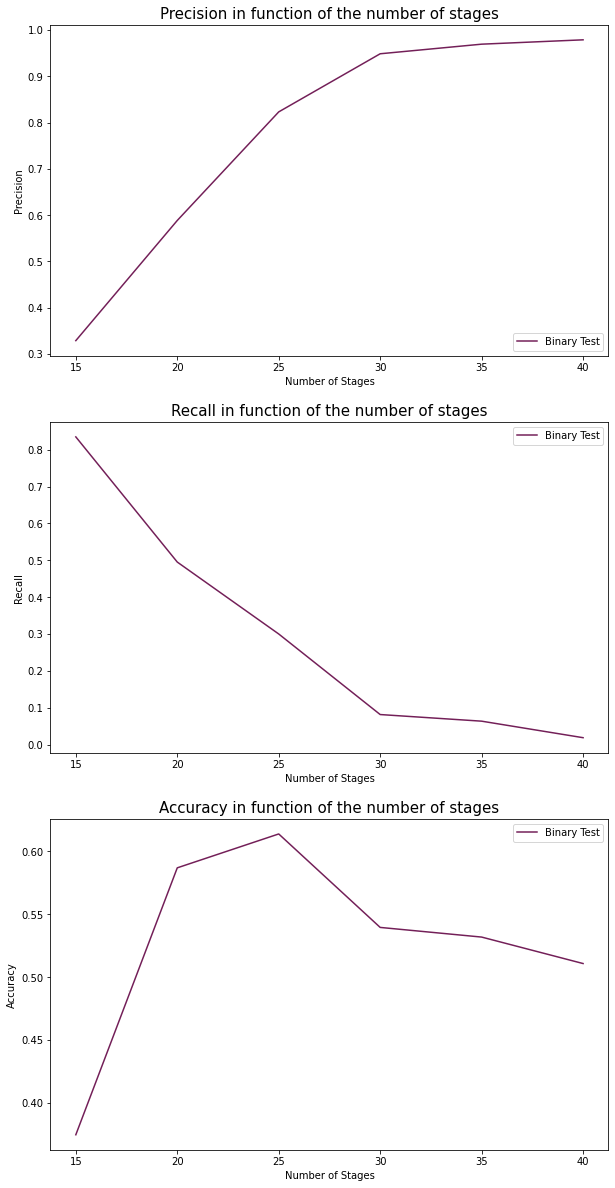

In [21]:
tp_acc_b = []

tp_pre = []
tp_pre_b = []

tp_rec = []
tp_rec_b = []

#for i in range(0,5):
#    pre = tp_arr[i] / (tp_arr[i] + fp_arr[i])
#    rec = tp_arr[i] / (tp_arr[i] + fn_arr[i])
    
#    tp_pre.append(pre)
#    tp_rec.append(rec)
    
for i in range(0,6):
    pre = tp_arr2_b[i] / (tp_arr2_b[i] + fp_arr2_b[i])
    rec = tp_arr2_b[i] / (tp_arr2_b[i] + fn_arr2_b[i])
    acc = (tp_arr2_b[i] + tn_arr2_b[i]) / (tp_arr2_b[i] + fp_arr2_b[i] + fn_arr2_b[i] + tn_arr2_b[i])
    
    tp_pre_b.append(pre)
    tp_rec_b.append(rec)
    tp_acc_b.append(acc)
    
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["15", "20", "25", "30", "35", "40"], tp_pre_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Number of Stages')
plt.ylabel('Precision')
plt.title('Precision in function of the number of stages',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["15", "20", "25", "30", "35", "40"], tp_rec_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Number of Stages')
plt.ylabel('Recall')
plt.title('Recall in function of the number of stages',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["15", "20", "25", "30", "35", "40"], tp_acc_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Number of Stages')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the number of stages',fontsize=15)

plt.show()

### Changing Hit Rate

#### Get Time Taken to Detect

In [22]:
path = "./ImageResources/Dataset/wider_face_split/wider_face_val_bbx_gt.txt" #Path to the test images

print("Just one image")
times_single = []
for hit_rate in ["0.95", "0.99", "0.999", "0.9995"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"hitrate/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+hit_rate+"hitrate.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, hit_rate+"hitrate.txt")
        break
    end = time.time()
    
    times_single.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + hit_rate + "hit rate")


print("Testing 100 Images")
times_multi = []
for hit_rate in ["0.95", "0.99", "0.999", "0.9995"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"hitrate/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+hit_rate+"hitrate.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))][:100]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, hit_rate+"hitrate.txt")

    end = time.time()
    times_multi.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + hit_rate + "hit rate")

Just one image
It took 0.0617518424987793 to finish results for 0.95hit rate
It took 0.41596508026123047 to finish results for 0.99hit rate
It took 1.383009672164917 to finish results for 0.999hit rate
It took 1.9025895595550537 to finish results for 0.9995hit rate
Testing 100 Images
It took 7.447278738021851 to finish results for 0.95hit rate
It took 45.047931432724 to finish results for 0.99hit rate
It took 140.25024580955505 to finish results for 0.999hit rate
It took 193.9789206981659 to finish results for 0.9995hit rate


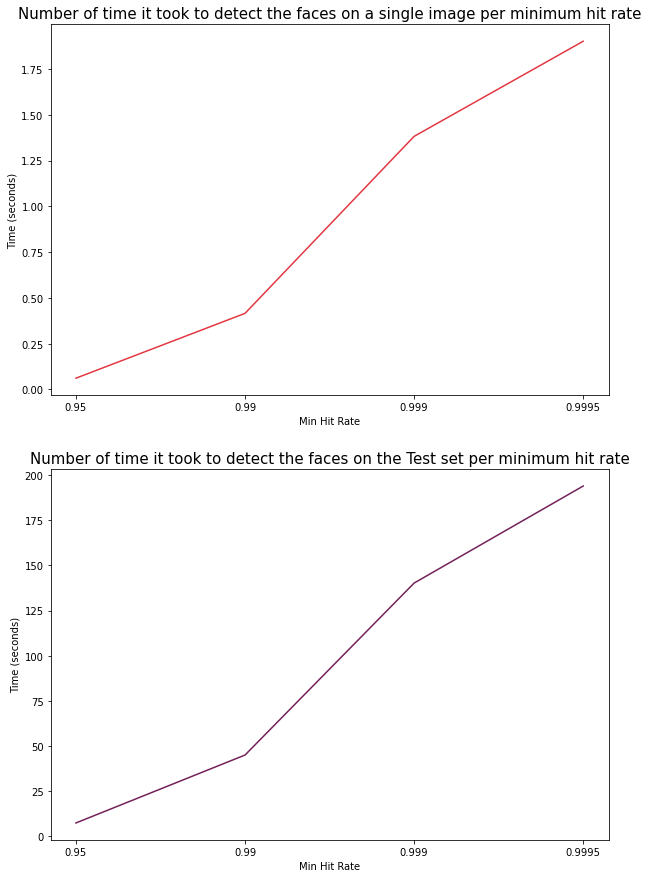

In [23]:
plt.figure(figsize = (10,15))

plt.subplot(2,1,1)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], times_single, color="#e33641")
plt.xlabel('Min Hit Rate')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on a single image per minimum hit rate',fontsize=15)

plt.subplot(2,1,2)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], times_multi, color="#731f58")
plt.xlabel('Min Hit Rate')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on the Test set per minimum hit rate',fontsize=15)
plt.show()

#### Test

In [26]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr2 = []
fp_arr2 = []
fn_arr2 = []

acc_arr2 = []
recall_arr2 = []

tp_arr_b = []
tn_arr_b = []
fp_arr_b = []
fn_arr_b = []

acc_arr2_b = []
recall_arr2_b = []

list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]
shuffle(list_imgs)

for hit_rate in ["0.95", "0.99", "0.999", "0.9995"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"hitrate/cascade.xml")
    
    """
    results = open("./CascadeClassifier/pred/"+hit_rate+"hitrate.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbours=6)
        writeResults(img,faces, hit_rate+"hitrate.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the trained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/"+hit_rate+"hitrate.txt", answers)
    
    tp_arr2.append(tp)
    fp_arr2.append(fp)
    fn_arr2.append(fn)"""
    
    results = open("./CascadeClassifier/pred/"+hit_rate+"hitrateBin.txt", "w")
    results.close()
    
    start = time.time()
    for img in list_imgs[:5000]:

        faces = detectFaces(classifier, img, minNeighbors=6)
        writeResults(img,faces, hit_rate+"hitrateBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/"+hit_rate+"hitrateBin.txt")
    
    tp_arr_b.append(tp)
    tn_arr_b.append(tn)
    fp_arr_b.append(fp)
    fn_arr_b.append(fn)
    
print(tp_arr_b)
print(fp_arr_b)
print(fn_arr_b)
print(tn_arr_b)

It took 20.931976079940796 to finish results for the pretrained model stages
It took 58.5265679359436 to finish results for the pretrained model stages
It took 106.92299556732178 to finish results for the pretrained model stages
It took 128.73555660247803 to finish results for the pretrained model stages
[1796, 5277, 6137, 6431]
[280, 2979, 6976, 7852]
[1485, 517, 308, 251]
[2300, 1730, 1331, 1242]


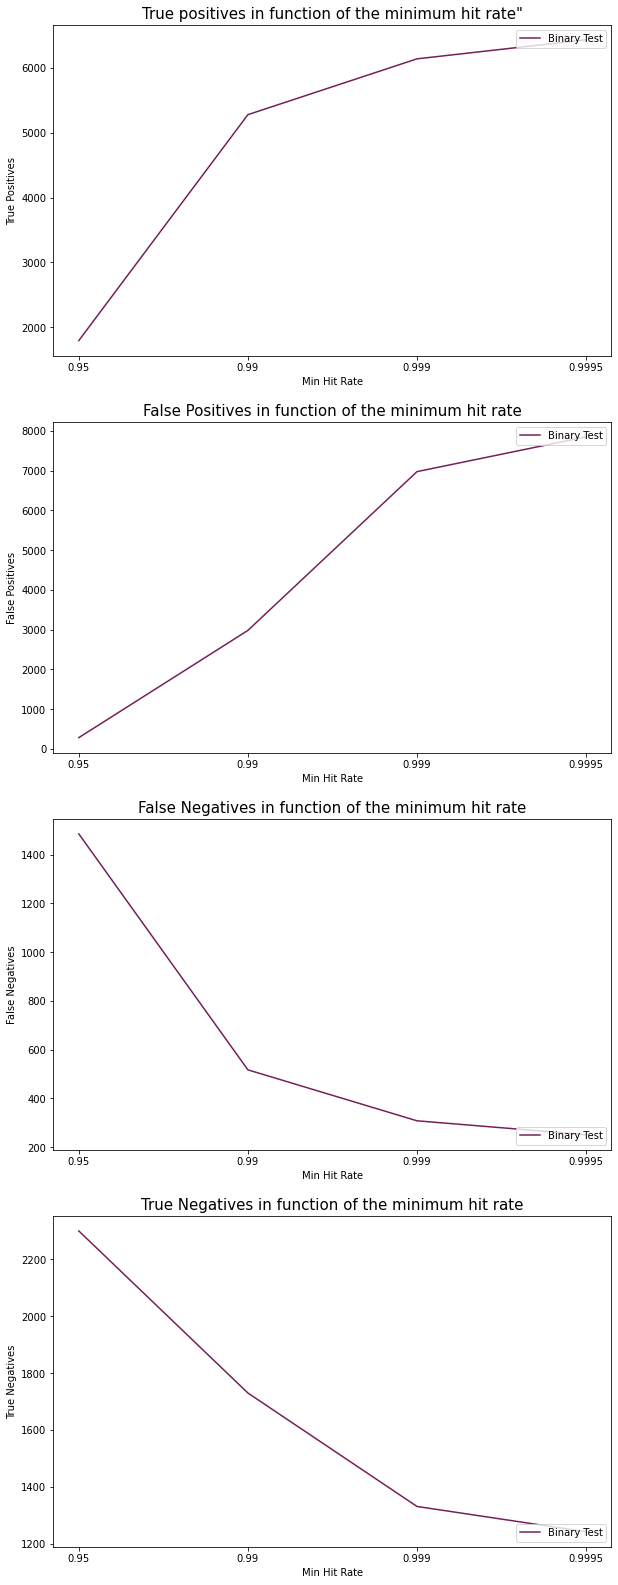

In [27]:
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], tp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Min Hit Rate')
plt.ylabel('True Positives')
plt.title('True positives in function of the minimum hit rate"',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], fp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Min Hit Rate')
plt.ylabel('False Positives')
plt.title('False Positives in function of the minimum hit rate',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], fn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Min Hit Rate')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the minimum hit rate',fontsize=15)

plt.subplot(4,1,4)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], tn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Min Hit Rate')
plt.ylabel('True Negatives')
plt.title('True Negatives in function of the minimum hit rate',fontsize=15)

plt.show()

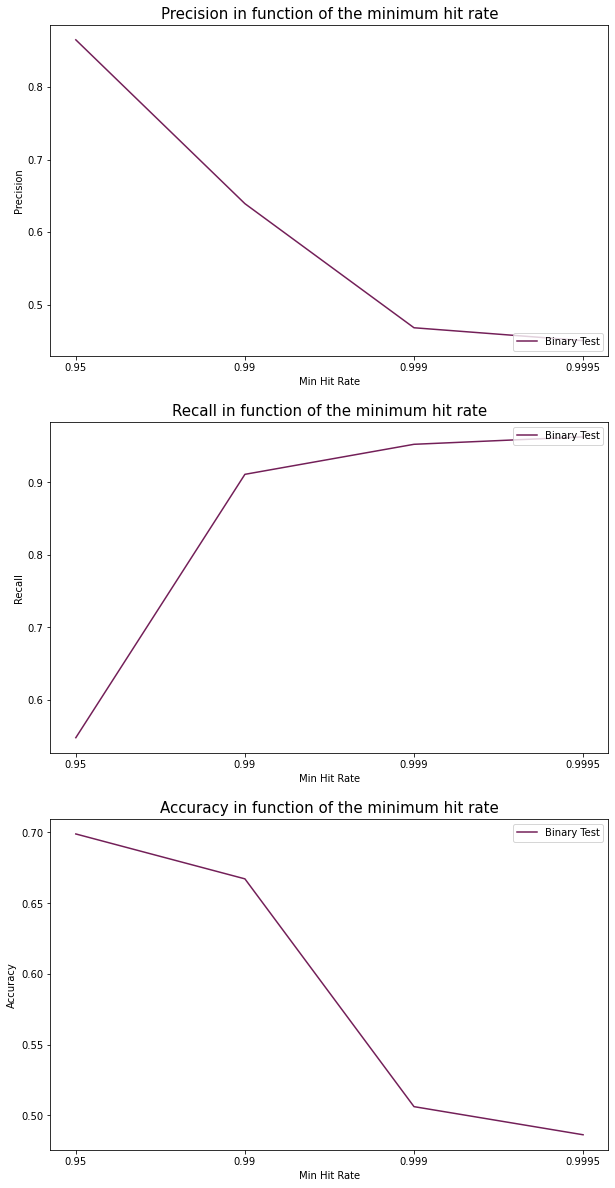

In [28]:
tp_acc_b = []

tp_pre_b = []

tp_rec_b = []

#for i in range(0,5):
#    pre = tp_arr[i] / (tp_arr[i] + fp_arr[i])
#    rec = tp_arr[i] / (tp_arr[i] + fn_arr[i])
    
#    tp_pre.append(pre)
#    tp_rec.append(rec)
    
for i in range(0,4):
    pre = tp_arr_b[i] / (tp_arr_b[i] + fp_arr_b[i])
    rec = tp_arr_b[i] / (tp_arr_b[i] + fn_arr_b[i])
    acc = (tp_arr_b[i] + tn_arr_b[i]) / (tp_arr_b[i] + fp_arr_b[i] + fn_arr_b[i] + tn_arr_b[i])
    
    tp_pre_b.append(pre)
    tp_rec_b.append(rec)
    tp_acc_b.append(acc)
    
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], tp_pre_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Min Hit Rate')
plt.ylabel('Precision')
plt.title('Precision in function of the minimum hit rate',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], tp_rec_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Min Hit Rate')
plt.ylabel('Recall')
plt.title('Recall in function of the minimum hit rate',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["0.95", "0.99", "0.999", "0.9995"], tp_acc_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Min Hit Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the minimum hit rate',fontsize=15)

plt.show()

### Changing False Alarm Rate

#### Get Time Taken to Detect

In [29]:
path = "./ImageResources/Dataset/wider_face_split/wider_face_val_bbx_gt.txt" #Path to the test images

print("Just one image")
times_single = []
for hit_rate in ["0.3", "0.4", "0.5", "0.6"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"falsealarm/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+hit_rate+"falsealarm.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, hit_rate+"falsealarm.txt")
        break
    end = time.time()
    
    times_single.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + hit_rate + "false alarm")


print("Testing 100 Images")
times_multi = []
for hit_rate in ["0.3", "0.4", "0.5", "0.6"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"falsealarm/cascade.xml")

    # Get values for our Test Set
    path = "./ImageResources/Dataset/WIDER_test/images"

    results = open("./CascadeClassifier/pred/"+hit_rate+"falsealarm.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))][:100]
    
    start = time.time()
    for img in list_imgs:
        faces = detectFaces(classifier, img)
        writeResults(img,faces, hit_rate+"falsealarm.txt")

    end = time.time()
    times_multi.append(end-start)
    
    print("It took " + str(end - start) + " to finish results for " + hit_rate + "falsealarm")

Just one image
It took 0.31746411323547363 to finish results for 0.3false alarm
It took 0.3759269714355469 to finish results for 0.4false alarm
It took 0.7494320869445801 to finish results for 0.5false alarm
It took 6.402801752090454 to finish results for 0.6false alarm
Testing 100 Images
It took 35.44716930389404 to finish results for 0.3falsealarm
It took 38.01312971115112 to finish results for 0.4falsealarm
It took 69.45486354827881 to finish results for 0.5falsealarm
It took 502.89424777030945 to finish results for 0.6falsealarm


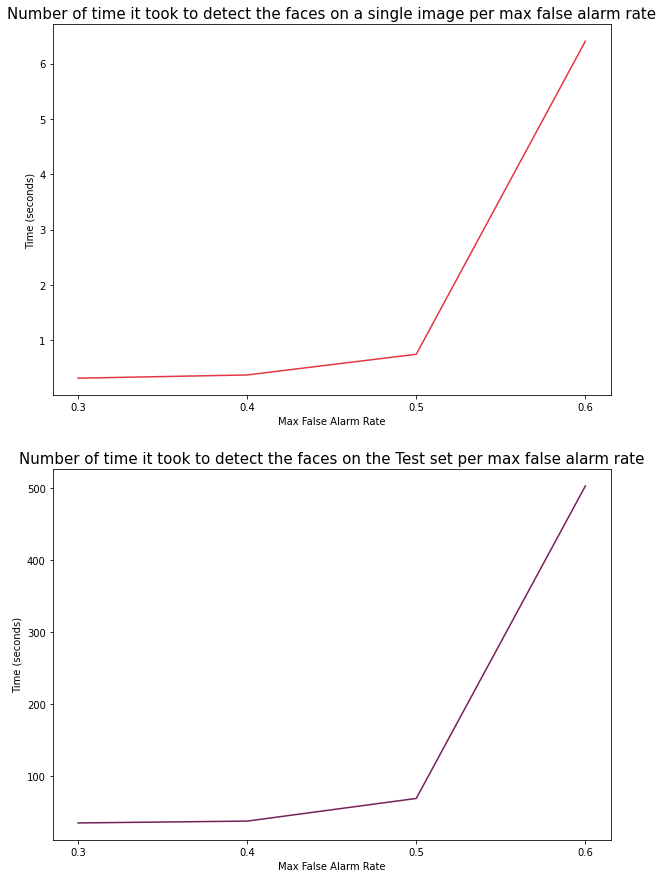

In [30]:
plt.figure(figsize = (10,15))

plt.subplot(2,1,1)
plt.plot(["0.3", "0.4", "0.5", "0.6"], times_single, color="#e33641")
plt.xlabel('Max False Alarm Rate')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on a single image per max false alarm rate',fontsize=15)

plt.subplot(2,1,2)
plt.plot(["0.3", "0.4", "0.5", "0.6"], times_multi, color="#731f58")
plt.xlabel('Max False Alarm Rate')
plt.ylabel('Time (seconds)')
plt.title('Number of time it took to detect the faces on the Test set per max false alarm rate',fontsize=15)
plt.show()

#### Test

In [31]:
path = "./ImageResources/Dataset/WIDER_test/images"
answers = "./ImageResources/Dataset/WIDER_test/test.txt"
bin_path = "./ImageResources/Dataset/WIDER_test/cropped_images"

tp_arr2 = []
fp_arr2 = []
fn_arr2 = []

acc_arr2 = []
recall_arr2 = []

tp_arr_b = []
tn_arr_b = []
fp_arr_b = []
fn_arr_b = []

acc_arr2_b = []
recall_arr2_b = []

for hit_rate in ["0.3", "0.4", "0.5", "0.6"]:
    classifier = initCascade("./CascadeClassifier/models/model"+hit_rate+"falsealarm/cascade.xml")
    
    """
    results = open("./CascadeClassifier/pred/"+hit_rate+"falsealarm.txt", "w")
    results.close()

    list_imgs = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    start = time.time()
    for img in list_imgs:

        faces = detectFaces(classifier, img, minNeighbours=6)
        writeResults(img,faces, hit_rate+"falsealarm.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the trained model stages")
    
    tp, fp, fn = compare_results("./CascadeClassifier/pred/"+hit_rate+"falsealarm.txt", answers)
    
    tp_arr2.append(tp)
    fp_arr2.append(fp)
    fn_arr2.append(fn)
    """
    results = open("./CascadeClassifier/pred/"+hit_rate+"falsealarmBin.txt", "w")
    results.close()

    list_imgs = [join(bin_path, f) for f in listdir(bin_path) if isfile(join(bin_path, f))]
    shuffle(list_imgs)    
    
    start = time.time()
    for img in list_imgs[:5000]:

        faces = detectFaces(classifier, img, minNeighbors=6)
        writeResults(img,faces, hit_rate+"falsealarmBin.txt")

    end = time.time()
    print("It took " + str(end - start) + " to finish results for the pretrained model stages")

    tp, tn, fp, fn = compare_bin_results(path, "./CascadeClassifier/pred/"+hit_rate+"falsealarmBin.txt")
    
    tp_arr_b.append(tp)
    tn_arr_b.append(tn)
    fp_arr_b.append(fp)
    fn_arr_b.append(fn)
    
print(tp_arr_b)
print(fp_arr_b)
print(fn_arr_b)
print(tn_arr_b)

It took 73.45971369743347 to finish results for the pretrained model stages
It took 78.12425255775452 to finish results for the pretrained model stages
It took 82.15570592880249 to finish results for the pretrained model stages
It took 120.47566437721252 to finish results for the pretrained model stages
[2033, 3252, 5885, 8520]
[225, 645, 3723, 20853]
[1274, 873, 457, 191]
[2364, 2209, 1636, 750]


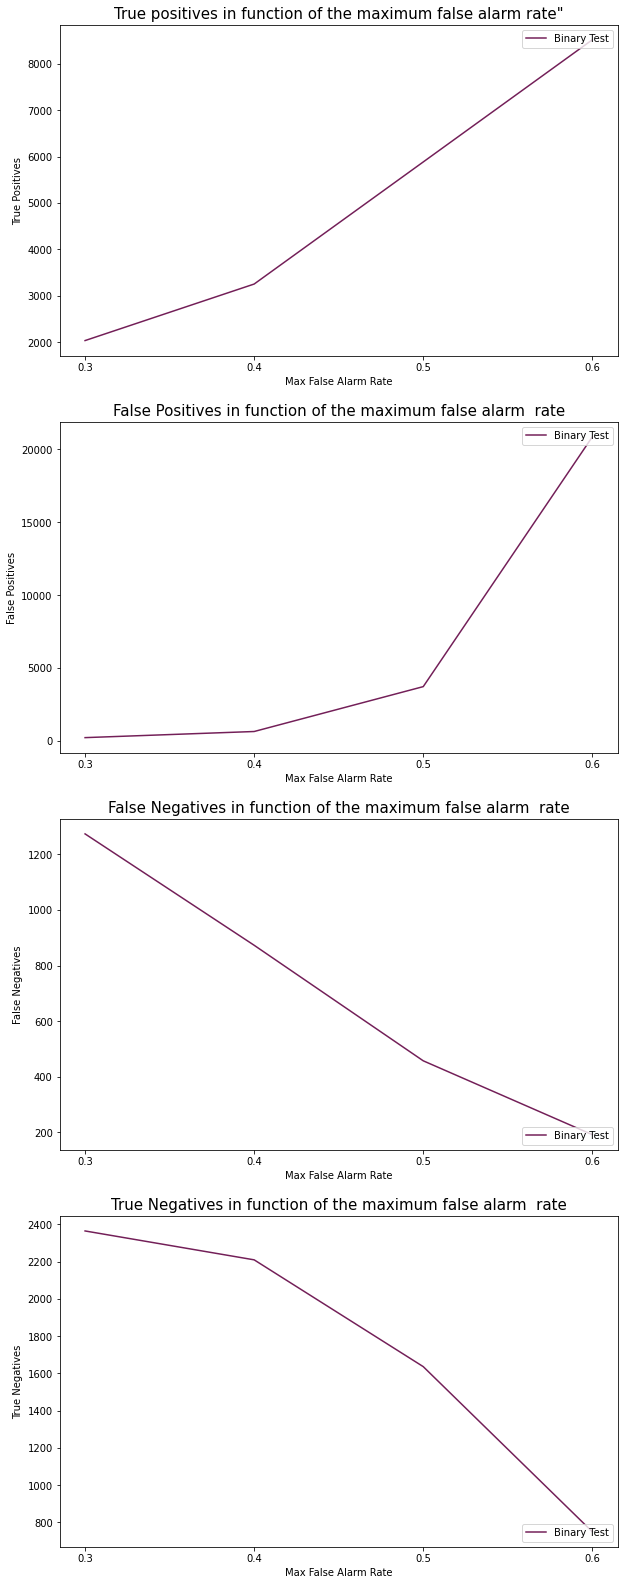

In [32]:
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["0.3", "0.4", "0.5", "0.6"], tp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('True Positives')
plt.title('True positives in function of the maximum false alarm rate"',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["0.3", "0.4", "0.5", "0.6"], fp_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('False Positives')
plt.title('False Positives in function of the maximum false alarm  rate',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["0.3", "0.4", "0.5", "0.6"], fn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('False Negatives')
plt.title('False Negatives in function of the maximum false alarm  rate',fontsize=15)

plt.subplot(4,1,4)
plt.plot(["0.3", "0.4", "0.5", "0.6"], tn_arr_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('True Negatives')
plt.title('True Negatives in function of the maximum false alarm  rate',fontsize=15)

plt.show()

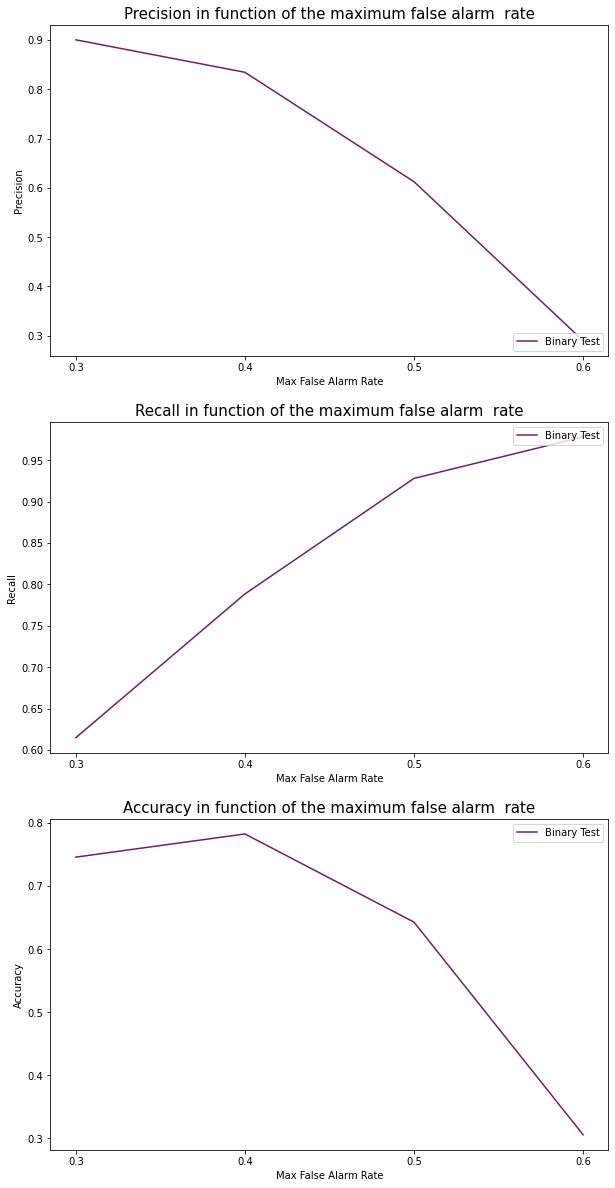

In [33]:
tp_acc_b = []

tp_pre = []
tp_pre_b = []

tp_rec = []
tp_rec_b = []
    
for i in range(0,4):
    pre = tp_arr_b[i] / (tp_arr_b[i] + fp_arr_b[i])
    rec = tp_arr_b[i] / (tp_arr_b[i] + fn_arr_b[i])
    acc = (tp_arr_b[i] + tn_arr_b[i]) / (tp_arr_b[i] + fp_arr_b[i] + fn_arr_b[i] + tn_arr_b[i])
    
    tp_pre_b.append(pre)
    tp_rec_b.append(rec)
    tp_acc_b.append(acc)
    
plt.figure(figsize = (10,28))
plt.subplot(4,1,1)
plt.plot(["0.3", "0.4", "0.5", "0.6"], tp_pre_b, color="#731f58", label="Binary Test")
plt.legend(loc='lower right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('Precision')
plt.title('Precision in function of the maximum false alarm  rate',fontsize=15)

plt.subplot(4,1,2)
plt.plot(["0.3", "0.4", "0.5", "0.6"], tp_rec_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('Recall')
plt.title('Recall in function of the maximum false alarm  rate',fontsize=15)

plt.subplot(4,1,3)
plt.plot(["0.3", "0.4", "0.5", "0.6"], tp_acc_b, color="#731f58", label="Binary Test")
plt.legend(loc='upper right')
plt.xlabel('Max False Alarm Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the maximum false alarm  rate',fontsize=15)

plt.show()